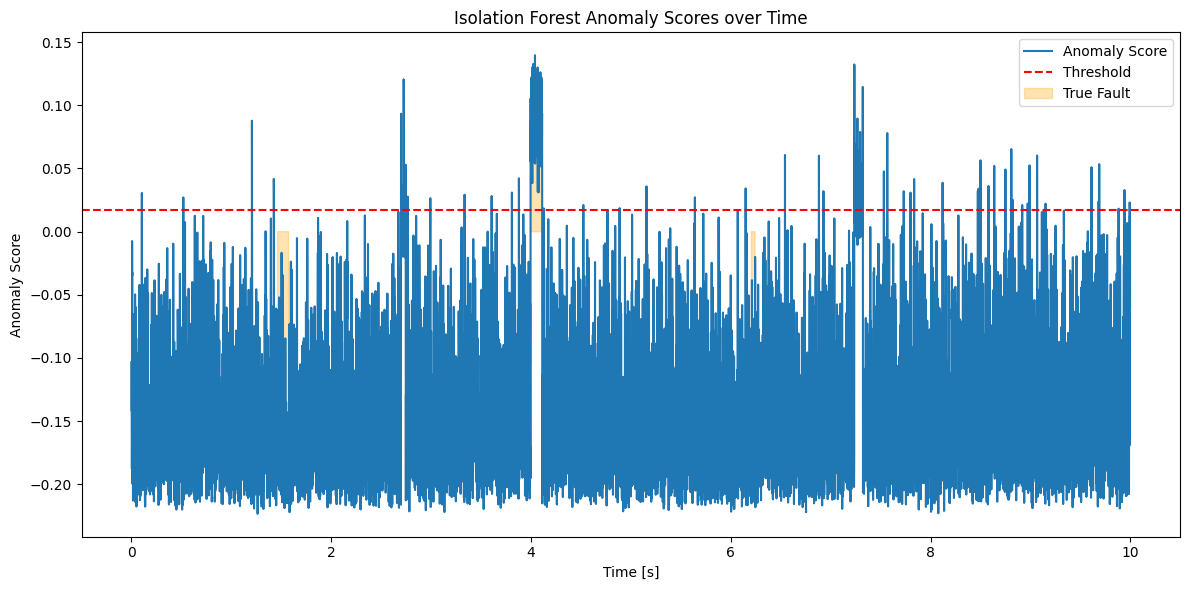

Confusion Matrix:
 [[9552   48]
 [ 228  170]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9600
           1       0.78      0.43      0.55       398

    accuracy                           0.97      9998
   macro avg       0.88      0.71      0.77      9998
weighted avg       0.97      0.97      0.97      9998

✅ Model and scaler saved.


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -----------------------------
# Load engineered features
# -----------------------------
df_feat = pd.read_csv("../data/cubesat_features.csv")

# -----------------------------
# Separate healthy and fault data
# -----------------------------
healthy_df = df_feat[df_feat["fault_label"] == 0]
fault_df   = df_feat[df_feat["fault_label"] == 1]

X_healthy = healthy_df[["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]].values
X_faulty  = fault_df[["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]].values

# -----------------------------
# Feature scaling
# -----------------------------
scaler = StandardScaler()
X_healthy_scaled = scaler.fit_transform(X_healthy)
X_faulty_scaled  = scaler.transform(X_faulty)

# -----------------------------
# Train Isolation Forest (on healthy data only)
# -----------------------------
iso = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,   # expected anomaly ratio
    random_state=42
)
iso.fit(X_healthy_scaled)

# -----------------------------
# Evaluate on both healthy + fault data
# -----------------------------
X_all = df_feat[["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]].values
X_all_scaled = scaler.transform(X_all)
scores = -iso.decision_function(X_all_scaled)  # higher = more anomalous
df_feat["anomaly_score"] = scores

# Default threshold
threshold = np.percentile(scores[df_feat["fault_label"] == 0], 99.5)
df_feat["predicted_fault"] = (df_feat["anomaly_score"] > threshold).astype(int)

# -----------------------------
# Visualize anomaly scores
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_feat["time_s"], df_feat["anomaly_score"], label="Anomaly Score")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.fill_between(df_feat["time_s"], 0, df_feat["anomaly_score"],
                 where=df_feat["fault_label"]==1, color="orange", alpha=0.3, label="True Fault")
plt.title("Isolation Forest Anomaly Scores over Time")
plt.xlabel("Time [s]")
plt.ylabel("Anomaly Score")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Simple evaluation
# -----------------------------
from sklearn.metrics import confusion_matrix, classification_report

y_true = df_feat["fault_label"]
y_pred = df_feat["predicted_fault"]

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Save the model and scaler
import joblib
joblib.dump(iso, "../models/iforest_model.pkl")
joblib.dump(scaler, "../models/feature_scaler.pkl")
print("✅ Model and scaler saved.")
